![header](images/header.png)

# Click That Recommendation Button
**Authors:** Jonathan Fetterolf, Matthew Duncan, Jasmine Huang, Michael Licul

# Business Understanding and Business Problem

The movie rental company, RedBox asked us to create and implement a recommendation system with the following goals:

1. Create a recommender model that allows users to input movie ratings and outputs movie suggestions
2. Store user ratings for future recommendation requests
3. Provide specific genre recommendations based on a users request

Successfully implemented recommender systems increase customer engagement, loyalty, satisfaction, and retention. All of these factors lead to an increase of sales.  

## Cost of Errors

The main cost of errors in prediction are losing user trust and loyalty. The goal of an accurate recommender system is to build loyalty and create a seamless user experience from initial recommendation to rental, if users do not find value in the recommendations provided than that loyalty is instantly lost.

# Data Understanding

**Important Note:** For the sake of being able to run the notebook completely through, the script to create a new user and provide movie ratings has been commented out. If you would like to test creating a new user, please uncomment the code and run the respective cell.

The `functions.py` script within this repo is required for this notebook to run properly if the new user code is uncommented.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise.prediction_algorithms import *
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

import gradio as gr

import warnings
warnings.filterwarnings('ignore')

import functions

## Initial Data

The data used in this notebook is from MovieLens. The dataset includes over 100,000 ratings of nearly 10,000 movies, made by 600 users. The data is imported from four different CSV files.

Further analysis of the data is discussed below:

In [2]:
#the four csv files provided
links_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [3]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Exploratory Data Analysis

### Exploring `links_df`

The DataFrame, ```links_df``` is a key to merge movie identifiers with IMDB Database and The Movie DataBase. We will be focusing on the MovieLens database for this analysis and will not need this file.

In [7]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Exploring `movies_df`

The DataFrame, ```movies_df``` will provide us with the title of movie (```title```) in relation to its unique identifier (```movieId```) and also contains information about the genre categories (```genres```) for each movie.

In [8]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies_df.shape

(9742, 3)

In [10]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
movies_df['title'].nunique()

9737

In [12]:
movies_df['title'].value_counts().head(10)

Saturn 3 (1980)                                2
Emma (1996)                                    2
Confessions of a Dangerous Mind (2002)         2
War of the Worlds (2005)                       2
Eros (2004)                                    2
Dolce Vita, La (1960)                          1
Double, The (2011)                             1
Justice League: Crisis on Two Earths (2010)    1
Horror of Dracula (Dracula) (1958)             1
Porky's (1982)                                 1
Name: title, dtype: int64

There are 9737 unique movie titles. Repeats for 5 movies:
- Emma (1996)                                   2
- Saturn 3 (1980)                               2
- Eros (2004)                                   2
- Confessions of a Dangerous Mind (2002)        2
- War of the Worlds (2005)                      2

Cleaning the text in the DataFrame.

In [13]:
movies_df['split_genres'] = movies_df['genres'].iloc[0:].apply(lambda x: x.title().split('|'))
movies_df['genres'] = movies_df['genres'].iloc[0:].apply(lambda x: x.lower())

Generating a bar chart, **Counts by Genre**

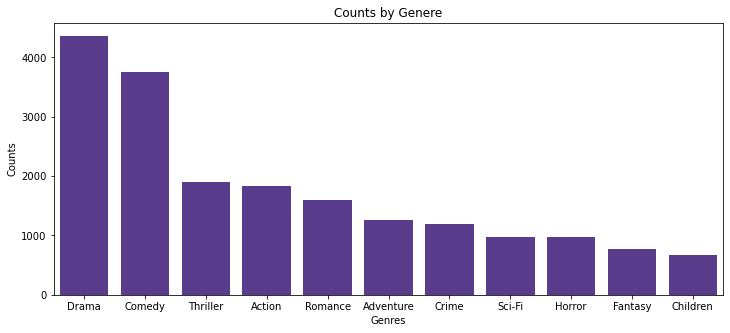

In [14]:
purple = ['#572f99']

genre_counts_names = functions.to_1D(movies_df['split_genres']).value_counts().index.tolist()
genre_counts_values = functions.to_1D(movies_df['split_genres']).value_counts().values


fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x=genre_counts_names[:11], y=genre_counts_values[:11], color='#572f99', ax=ax)
ax.set_title('Counts by Genere')
ax.set_ylabel('Counts')
ax.set_xlabel('Genres');

This chart shows us the most highly represented genres in the DataFrame. A successful recommender system would not necessarily direct users to movies within these genres.

In [15]:
genre_counts_names[0].title()

'Drama'

### Exploring `ratings_df`

The DataFrame, ```ratings_df``` will be ther primary DataFrame used in the analysis. It includes relevant information including `userId`, `rating`, and `movieId`.

In [16]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [17]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [18]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [19]:
# The 10 movies with the most reviews
ratings_df.groupby('movieId').count().sort_values('userId', ascending=False).head(10)

,userId,rating,timestamp
movieId,,,
356,329,329,329
318,317,317,317
296,307,307,307
593,279,279,279
2571,278,278,278
260,251,251,251
480,238,238,238
110,237,237,237
589,224,224,224


In [20]:
# the 10 movies with the highest ratings
ratings_df.groupby('movieId').mean().sort_values('rating', ascending=False).head(10)

,userId,rating,timestamp
movieId,,,
88448,483.0,5.0,1.315438e+09
100556,462.0,5.0,1.456151e+09
143031,89.0,5.0,1.520409e+09
143511,105.0,5.0,1.526207e+09
143559,89.0,5.0,1.520410e+09
6201,474.0,5.0,1.100120e+09
102217,63.0,5.0,1.443200e+09
102084,380.0,5.0,1.493422e+09
6192,182.0,5.0,1.063275e+09


In [21]:
# the 10 users with the most reviews
ratings_df.groupby('userId').count().sort_values('rating', ascending=False).head(10)

,movieId,rating,timestamp
userId,,,
414,2698,2698,2698
599,2478,2478,2478
474,2108,2108,2108
448,1864,1864,1864
274,1346,1346,1346
610,1302,1302,1302
68,1260,1260,1260
380,1218,1218,1218
606,1115,1115,1115


 We will drop the `timestamp` column as it is not relevant for this analysis.

In [22]:
ratings_df.drop('timestamp', axis=1, inplace=True)

### Exploring `tags_df`

The DataFrame, ```tags_df``` will be helpful for analysis as it provides keyword insights to each of the films. 

In [23]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [24]:
tags_df.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [25]:
# users with the most comments on movies
tags_df.groupby('userId').count().sort_values('tag', ascending=False).head(10)

,movieId,tag,timestamp
userId,,,
474,1507,1507,1507
567,432,432,432
62,370,370,370
599,323,323,323
477,280,280,280
424,273,273,273
537,100,100,100
125,48,48,48
357,45,45,45


In [26]:
#cleaning tags
tags_df2 = tags_df
tags_df2['tag_clean'] = tags_df2['tag'].iloc[0:].apply(lambda x: x.title().replace(' ', ''))
tags_df_clean = tags_df2.drop(['tag', 'timestamp'], axis=1)
tags_df_clean.head()

,userId,movieId,tag_clean
0,2,60756,Funny
1,2,60756,HighlyQuotable
2,2,60756,WillFerrell
3,2,89774,BoxingStory
4,2,89774,Mma


Generating a bar chart, **Counts by Movie Tag**

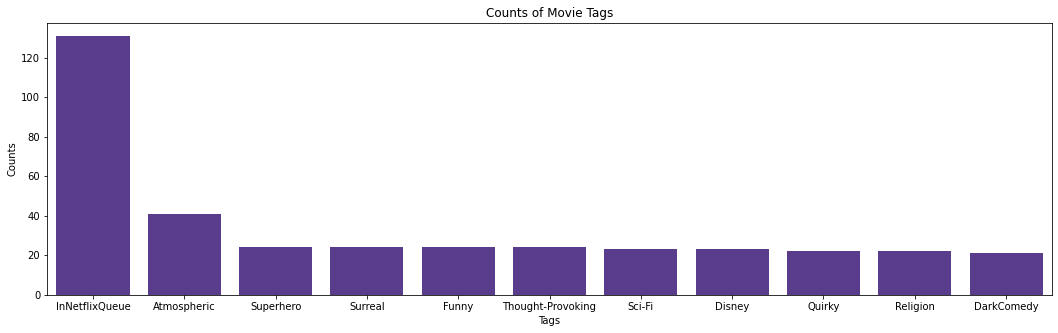

In [27]:
tag_counts_names = tags_df_clean['tag_clean'].value_counts().index
tag_counts_values = tags_df_clean['tag_clean'].value_counts().values

fig, ax = plt.subplots(figsize=(18,5))
# ax.bar(tag_counts_names[:11], tag_counts_values[:11])

sns.barplot(x=tag_counts_names[:11], y=tag_counts_values[:11], color='#572f99', ax=ax)
ax.set_title('Counts of Movie Tags')
ax.set_ylabel('Counts')
ax.set_xlabel('Tags');

### Combined DataFrame

To better understand and work with the separate files, they have been merged to one, larger working file. After cleaning the merged DataFrame, we have 100,836 reviews for 9,724 movies.

In [28]:
# Merging the ratings data with movie titles and genres
merged_df = ratings_df.merge(movies_df, how='outer', on='movieId')
merged_df.head(3)

,userId,movieId,rating,title,genres,split_genres
0,1.0,1,4.0,Toy Story (1995),adventure|animation|children|comedy|fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,5.0,1,4.0,Toy Story (1995),adventure|animation|children|comedy|fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,7.0,1,4.5,Toy Story (1995),adventure|animation|children|comedy|fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"


In [29]:
# Checking for nulls after merging
merged_df.isna().sum()

userId          18
movieId          0
rating          18
title            0
genres           0
split_genres     0
dtype: int64

In [30]:
# 18 movies do not have any reviews 
merged_df.tail(20)

,userId,movieId,rating,title,genres,split_genres
100834,610.0,163937,3.5,Blair Witch (2016),horror|thriller,"[Horror, Thriller]"
100835,610.0,163981,3.5,31 (2016),horror,[Horror]
100836,NaN,1076,NaN,"Innocents, The (1961)",drama|horror|thriller,"[Drama, Horror, Thriller]"
100837,NaN,2939,NaN,Niagara (1953),drama|thriller,"[Drama, Thriller]"
100838,NaN,3338,NaN,For All Mankind (1989),documentary,[Documentary]
100839,NaN,3456,NaN,"Color of Paradise, The (Rang-e khoda) (1999)",drama,[Drama]
100840,NaN,4194,NaN,I Know Where I'm Going! (1945),drama|romance|war,"[Drama, Romance, War]"
100841,NaN,5721,NaN,"Chosen, The (1981)",drama,[Drama]
100842,NaN,6668,NaN,"Road Home, The (Wo de fu qin mu qin) (1999)",drama|romance,"[Drama, Romance]"
100843,NaN,6849,NaN,Scrooge (1970),drama|fantasy|musical,"[Drama, Fantasy, Musical]"


In [31]:
# Dropping nulls in data
merged_df.dropna(inplace=True)
merged_df.isna().sum()

userId          0
movieId         0
rating          0
title           0
genres          0
split_genres    0
dtype: int64

In [32]:
merged_df.shape

(100836, 6)

In [33]:
merged_df['movieId'].nunique()

9724

# Modeling

We use Surprise library for this analysis that limits data inputs to three columns of information.

Here are the columns used:

- `user_Id`
- `movie_Id`
- `rating`

In [34]:
# Adjusting the dataframe for modeling purposes
model_df = merged_df.drop(['title', 'genres', 'split_genres'], axis=1)

In [35]:
# Contains all movie ratings and the unique identifiers for user and movie
model_df.head()

,userId,movieId,rating
0,1.0,1,4.0
1,5.0,1,4.0
2,7.0,1,4.5
3,15.0,1,2.5
4,17.0,1,4.5


In [36]:
# Converting model_df to surprise accessible data
reader = Reader()
data = Dataset.load_from_df(model_df,reader)

In [37]:
# Setting Train/Test split
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [38]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  610 

Number of items:  8982


## First Baseline Model

Baseline model using Surprise's `BaselineOnly` algorithm:

In [39]:
baseline = BaselineOnly()
baseline.fit(trainset)
base_predictions = baseline.test(testset)

Estimating biases using als...


In [40]:
accuracy.rmse(base_predictions)

RMSE: 0.8734


0.8734341181528673

In [41]:
accuracy.mae(base_predictions)

MAE:  0.6722


0.6722070558104862

Results from the baseline model are pretty good with an RMSE of .87 and and MAE of .67.

### Cross-Validate Baseline Model

Here, we set up a cross-validation model in order to improve from the results of the baseline model:

In [42]:
cv = cross_validate(baseline, data, n_jobs=3)

In [43]:
for item in cv.items():
    print(item[0])
    print(np.mean(item[-1]))

test_rmse
0.8726897318250633
test_mae
0.6729733596771393
fit_time
0.10417509078979492
test_time
0.16513819694519044


## Checking Other Models

To ensure we're using the best model for our analysis, we will be running all potential algorithms through three-fold cross-validation. 

Our baseline model is still one of the top performers, though SVD++ provided the best results with a mean MAE of .668 and a mean RMSE of .87.

In [44]:
models_list = [NormalPredictor(), BaselineOnly(), KNNBaseline(random_state=42),
               KNNBasic(random_state=42), KNNWithMeans(random_state=42), 
               KNNWithZScore(random_state=42), SVD(random_state=42), 
               SVDpp(random_state=42), NMF(random_state=42), SlopeOne(), 
               CoClustering(random_state=42)]

In [45]:
results_df = pd.DataFrame()

for model in models_list:
    model_dict = {}
    temp_model = cross_validate(model, data, cv=3, n_jobs=3, verbose=False)
    model_dict['model'] = model
    for item in temp_model.items():
        model_dict[f"mean_{item[0]}"] = np.mean(item[-1])
    results_df = results_df.append(model_dict, ignore_index=True, sort=False)

In [46]:
results_df.sort_values('mean_test_mae')

,mean_fit_time,mean_test_mae,mean_test_rmse,mean_test_time,model
7,1132.970471,0.665483,0.867268,28.007585,<surprise.prediction_algorithms.matrix_factori...
2,0.482345,0.673431,0.881050,8.789276,<surprise.prediction_algorithms.knns.KNNBaseli...
1,0.141259,0.675896,0.876039,0.471750,<surprise.prediction_algorithms.baseline_only....
6,12.080156,0.677365,0.880688,0.651790,<surprise.prediction_algorithms.matrix_factori...
5,0.490161,0.686072,0.904179,8.459545,<surprise.prediction_algorithms.knns.KNNWithZS...
4,0.357277,0.690777,0.903945,7.378775,<surprise.prediction_algorithms.knns.KNNWithMe...
9,7.760462,0.696626,0.910942,25.003516,<surprise.prediction_algorithms.slope_one.Slop...
8,15.197630,0.717927,0.935477,0.669214,<surprise.prediction_algorithms.matrix_factori...
3,0.313766,0.734756,0.957783,6.109517,<surprise.prediction_algorithms.knns.KNNBasic ...
10,5.641926,0.736910,0.952159,0.607326,<surprise.prediction_algorithms.co_clustering....


## GridSearch of Top Model

To ensure that our top model is living up to its best potential, we are completing a gridsearch of SVD++ to find the best hyperparameters. Several iterations of GridSearch were completed and the search has been modified to adjust for past iterations (for instance `n_factors` continuously performed best with 20 factors and to speed up the search, other numbers were removed). Random state has been set for reproducibility.

For both RMSE and MAE metrics, our model performed best with:
- `n_factors` = 20
- `reg_all` = .01
- `lr_all` = .01
- `n_epochs` = 30

Utilizing GridSearch, we were able to reduce both error metrics. MAE was reduced to .662 from .668 and RMSE was reduced to .861 from .87. We will be using this model with the tuned parameters for our predictions.

**Note:** For the sake of those looking to run the notebook. GridSearch has been commented out due to the length of the run time. It takes several hours to complete. 

In [51]:
# Setting up final model
# params = {'n_factors': [20],
#          'reg_all': np.linspace(.001, .1, 4),
#          'lr_all': np.linspace(.001, .01, 4),
#          'n_epochs': [20, 30],
#          'random_state': [42]}


# model = GridSearchCV(SVDpp, params, cv=3, n_jobs=4)
# model.fit(data)

In [52]:
# model.best_params

{'rmse': {'n_factors': 20,
  'reg_all': 0.1,
  'lr_all': 0.01,
  'n_epochs': 30,
  'random_state': 42},
 'mae': {'n_factors': 20,
  'reg_all': 0.1,
  'lr_all': 0.01,
  'n_epochs': 30,
  'random_state': 42}}

In [53]:
# model.best_score

{'rmse': 0.8614322566345662, 'mae': 0.661554771143182}

## Final Model

We are creating a final model based on the results of our GridSearch.

- `n_factors` = 20
- `reg_all` = .01
- `lr_all` = .01
- `n_epochs` = 30

In [47]:
# Creating final model
final_model = SVDpp(n_factors=20, reg_all=.01, lr_all=.01, n_epochs=30, random_state=42)
final_model.fit(trainset)
final_predictions = final_model.test(testset)

In [48]:
accuracy.rmse(final_predictions)

RMSE: 0.9103


0.9102514874968484

In [49]:
accuracy.mae(final_predictions)

MAE:  0.6952


0.6952301182297183

### Cross-Validating

Final cross-validated results provide us with a mean MAE of .705 and a mean RMSE of .92. Time to predict the test set took an average of 4 seconds.

In [50]:
# Double checking results of final model through cross validation
cv = cross_validate(final_model, data, n_jobs=-1, cv=3)

for item in cv.items():
    print(item[0])
    print(np.mean(item[-1]))

test_rmse
0.9200303697537827
test_mae
0.704346350885274
fit_time
877.7063782215118
test_time
13.190170367558798


# New Users and Predictions

Using the Python script located in the functions.py file within this repo. We are able to create new users who can provide movie ratings and save them to their profile. Users are able to request a number of recommended movies from 1-50 and can specify if they are interested in a specific genre.

When users create a new profile, they will be asked to create a username and password that can be used to access ratings that they have previously submitted. Users are able to make new ratings after logging back in to their profile or skip ahead to just pulling recommendations.

**Important Note:** For the sake of being able to run the notebook completely through, the script to create a new user and provide movie ratings has been commented out. If you would like to test creating a new user, please uncomment the code and run the respective cell.

In [51]:
# creating new user df and adding columns for username and password
new_user_df = merged_df.copy()
new_user_df['username'] = np.nan
new_user_df['password'] = np.nan

In [52]:
new_user_df.tail()

,userId,movieId,rating,title,genres,split_genres,username,password
100831,610.0,160341,2.5,Bloodmoon (1997),action|thriller,"[Action, Thriller]",NaN,NaN
100832,610.0,160527,4.5,Sympathy for the Underdog (1971),action|crime|drama,"[Action, Crime, Drama]",NaN,NaN
100833,610.0,160836,3.0,Hazard (2005),action|drama|thriller,"[Action, Drama, Thriller]",NaN,NaN
100834,610.0,163937,3.5,Blair Witch (2016),horror|thriller,"[Horror, Thriller]",NaN,NaN
100835,610.0,163981,3.5,31 (2016),horror,[Horror],NaN,NaN


In [53]:
# Test user with test rating
test_user = {'userId':611, 
             'movieId':1, 
             'rating':5, 
             'title': 'Toy Story (1995)', 
             'genres': 'Adventure|Animation|Children|Comedy|Fantasy', 
             'username': 'test_user', 
             'password': 'test_user'}

In [54]:
# Adding test user to new_user_df
new_user_df = new_user_df.append(test_user, ignore_index=True)
new_user_df.tail()

,userId,movieId,rating,title,genres,split_genres,username,password
100832,610.0,160527,4.5,Sympathy for the Underdog (1971),action|crime|drama,"[Action, Crime, Drama]",NaN,NaN
100833,610.0,160836,3.0,Hazard (2005),action|drama|thriller,"[Action, Drama, Thriller]",NaN,NaN
100834,610.0,163937,3.5,Blair Witch (2016),horror|thriller,"[Horror, Thriller]",NaN,NaN
100835,610.0,163981,3.5,31 (2016),horror,[Horror],NaN,NaN
100836,611.0,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,test_user,test_user


In [65]:
# new_user_df = functions.start_program(new_user_df, movies_df, model=final_model)

(Type 'quit' at any time to exit.) 

Are you a new user? (yes/no): yes
Please enter a unique username: test_user2
Please enter a password: test_user2

Welcome! Your new account is created...

You need at least 5 reviews before we can make recommendations.

(Type 'quit' to stop rating movies.) 

Please rate the movie 1-5. If you have not seen the movie, type "n" to skip: 

['Ring, The (2002)']
Rating: 
4
Saving rating to temporary memory...


You need at least 5 reviews before we can make recommendations.

(Type 'quit' to stop rating movies.) 

Please rate the movie 1-5. If you have not seen the movie, type "n" to skip: 

['Harry Potter and the Goblet of Fire (2005)']
Rating: 
5
Saving rating to temporary memory...


You need at least 5 reviews before we can make recommendations.

(Type 'quit' to stop rating movies.) 

Please rate the movie 1-5. If you have not seen the movie, type "n" to skip: 

['Clockwork Orange, A (1971)']
Rating: 
5
Saving rating to temporary memory...


You need a

In [67]:
new_user_df.tail(10)

,userId,movieId,rating,title,genres,split_genres,username,password
100834,610.0,163937.0,3.5,Blair Witch (2016),horror|thriller,"[Horror, Thriller]",NaN,NaN
100835,610.0,163981.0,3.5,31 (2016),horror,[Horror],NaN,NaN
100836,611.0,1.0,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,test_user,test_user
100837,612.0,5679.0,4.0,"Ring, The (2002)",horror|mystery|thriller,NaN,test_user2,test_user2
100838,612.0,40815.0,5.0,Harry Potter and the Goblet of Fire (2005),adventure|fantasy|thriller|imax,NaN,test_user2,test_user2
100839,612.0,1206.0,5.0,"Clockwork Orange, A (1971)",crime|drama|sci-fi|thriller,NaN,test_user2,test_user2
100840,612.0,2916.0,2.0,Total Recall (1990),action|adventure|sci-fi|thriller,NaN,test_user2,test_user2
100841,612.0,377.0,2.0,Speed (1994),action|romance|thriller,NaN,test_user2,test_user2
100842,612.0,2716.0,4.0,Ghostbusters (a.k.a. Ghost Busters) (1984),action|comedy|sci-fi,NaN,test_user2,test_user2
100843,612.0,2700.0,2.0,"South Park: Bigger, Longer and Uncut (1999)",animation|comedy|musical,NaN,test_user2,test_user2


# Deployment Proof of Concept

As part of this project, we have began creating a deployable app utilizing Gradio. The app is not finished but has some functionality below as a proof of concept.

In [55]:
test_predicted = functions.test_predict(user = 2, dataframe = new_user_df, movies_df=movies_df, model=final_model)

In [64]:
test_predicted.head()

,title,prediction,genres,split_genres
8292,"Day of the Doctor, The (2013)",4.765310,adventure|drama|sci-fi,"[Adventure, Drama, Sci-Fi]"
879,Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.749518,drama,[Drama]
2965,"Legend of Drunken Master, The (Jui kuen II) (1...",4.745295,action|comedy,"[Action, Comedy]"
7077,(500) Days of Summer (2009),4.735017,comedy|drama|romance,"[Comedy, Drama, Romance]"
9599,"Three Billboards Outside Ebbing, Missouri (2017)",4.653970,crime|drama,"[Crime, Drama]"


In [60]:
final_predictions = test_predicted.copy()

def movie_recommendation(rating, genre, choice):

    # slicing dataframe to include only movies with a given rating or above
    final_predictions = (test_predicted.copy())
    app_output = final_predictions[final_predictions['prediction'] > rating]
    #filtering dataframe to only include selected genre
    app_output = app_output[app_output['genres'].str.contains(genre.lower())]
    # Selecting only the two relevant columns
    app_output = app_output[['title', 'prediction']]
    #renaming columns for output
    app_output.rename(columns={'prediction':'Predicted Rating', 'title': 'Title'}, inplace=True)
    
    # creating slices for number of movies to output
    top_5 = functions.top_slice(0, 5, app_output)
    top_10 = functions.top_slice(0, 10, app_output)
    top_20 = functions.top_slice(0, 20, app_output)
    second_10 = functions.top_slice(10, 20, app_output)
    bottom_5 = functions.top_slice(-5, None, app_output)
    bottom_10 = functions.top_slice(-10, None, app_output)
    
    # Storing slices in dictionary
    choice_dict = {'Top 5':top_5, 'Top 10':top_10, 'Top 20':top_20, 'Second 10': second_10, 'Bottom 5': bottom_5, 'Bottom 10':bottom_10}

    return choice_dict[choice]

In [61]:
genre_list = []
for i in movies_df['split_genres']:
    for x in i:
        if x != '(No Genres Listed)':
            genre_list.append(x)
        
        
genre_list = list(set(genre_list))

In [62]:
# Gradio
choice_list = ['Top 5', 'Top 10', 'Top 20', 'Second 10', 'Bottom 5', 'Bottom 10']
rating = gr.components.Slider(1, 5, step=1, label='Movies with ratings higher than:')
genre = gr.inputs.Dropdown(genre_list, label='Pick a movie genre:')
choice = gr.inputs.Radio(choice_list, label='Choose the recommended movies list:')
outputs = gr.Dataframe(headers=["Title", "Predicted Rating"])


demo =gr.Interface(fn= movie_recommendation,
             inputs=[rating, genre, choice],
             outputs=outputs,
             description='What movie recommendations would you like today?',
             title= "Movie Recommendations")

In [63]:
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Results/Conclusions

Our final model operates with a cross-validated mean absolute of error of .705 and a Root Mean Squared Error of .920.


This means we have an average difference between the predicted ratings and the actual ratings of .705 of 1 point on a scale of .5 to 5. It makes this prediction in about 4 seconds.

## Further Exploration/Questions

### More Data
We would like to get more data in order to update and retrain the recommender system. More data likely means more accurate predictions. 

In addition, we have data in the form of movies tags that we were not able to incorporate into this model. Given more time, we would like to utilize user feedback in the form of tags.

### Algorithms
Given more time we'd like to utilize GridSearch on different algorithms for this model. We started by picking the best algorithm from untuned results, though further tuning of other prediction algorithms has the potential of outperforming the model we have selected.

### User Feedback
It would be nice to include a way to incorporate user feedback on recommendations as part of the deployed app. This could help to gather more data and to make our model more accurate.

Allowing users to rate movies that they watch after our recommendation would be an additional performance check for the validity of the model.

### Deployment

We would like to be able to deploy the app to the public if given more time and resources to host our model in the cloud.